### This assumes that one has a broad spectrum as an input

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from Biquad.Biquad_Daq import Biquad_Daq
from Waveforms.Waveform import Waveform

from Utils.PlotTools import PlottingTools as pt

import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual, HBox
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
daq = Biquad_Daq(None, None, 4, 2**10)

Turning on SYNC
Turning off SYNC


In [2]:
def capture_extended(loop=6):
    filttered_arr = np.array([])
    unfilterred_arr = np.array([])
    for i in range(loop):
        daq.JupyterAcquire()
        unfilterred_arr = np.concatenate((unfilterred_arr, daq.waveforms[0].waveform))
        filttered_arr = np.concatenate((filttered_arr, daq.waveforms[2].waveform))
        
    return Waveform(filttered_arr), Waveform(unfilterred_arr)

In [3]:
def capture_loop(iterations, loop=6):
    S21_arr = []
    group_delay_arr = []

    N = 512*loop
    T = 3.E9
    dt = 1/T
    
    xf = np.linspace(0.0, 1.0 / (2 * dt), N // 2)
    
    for i in range (iterations):
        filterred, raw = capture_extended(loop)
        
        filterred.setFreqFFT()
        raw.setFreqFFT()
        
        S21 = filterred.fft_result/raw.fft_result
        
        ##Group Delay
        phase_response = np.angle(S21[:N//2])
              
        unwrapped_phase = np.unwrap(phase_response)
              
        group_delay = -np.diff(unwrapped_phase) / np.diff(xf)
        
        S21_arr.append(S21)
        group_delay_arr.append(group_delay)
        
    S21_mean = [sum(x) / len(S21_arr) for x in zip(*S21_arr)]
    group_delay_mean = [sum(x) / len(group_delay_arr) for x in zip(*group_delay_arr)]
    S21_log_mag = 20 * np.log10(np.abs(S21_mean[:N//2]))
    
    return xf, S21_log_mag, group_delay_mean

In [4]:
def update_coef(A, B, P, Theta):
    
    daq.setA(A)
    daq.setB(B)
    daq.setP(P)
    daq.setTheta(np.pi*Theta)
    
    daq.set_single_zero_fir()
    daq.set_f_fir()
    daq.set_g_fir()
    daq.set_F_fir()
    daq.set_G_fir()
    daq.set_pole_coef()
    # daq.set_incremental()

In [5]:
A_slider = widgets.FloatSlider(min=-8, max=7.9, step=0.05, value=-1.05, description='A:', continuous_update=False)
B_slider = widgets.FloatSlider(min=-8, max=7.9, step=0.05, value=1.9, description='B:', continuous_update=False)
P_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.65, description='P:', continuous_update=False)
Theta_slider = widgets.FloatSlider(min=0, max=2, step=0.01, value=1.6, description='Theta:', continuous_update=False)
    
plot_output = widgets.Output()
    
def update(change):
    with plot_output:
        plot_output.clear_output(wait=True)
        update_coef(A_slider.value, B_slider.value, P_slider.value, Theta_slider.value)
    
A_slider.observe(update, names='value')
B_slider.observe(update, names='value')
P_slider.observe(update, names='value')
Theta_slider.observe(update, names='value')

slider_box = widgets.HBox([A_slider, B_slider, P_slider, Theta_slider])
ui = widgets.VBox([slider_box, plot_output])

display(ui)

update(None)

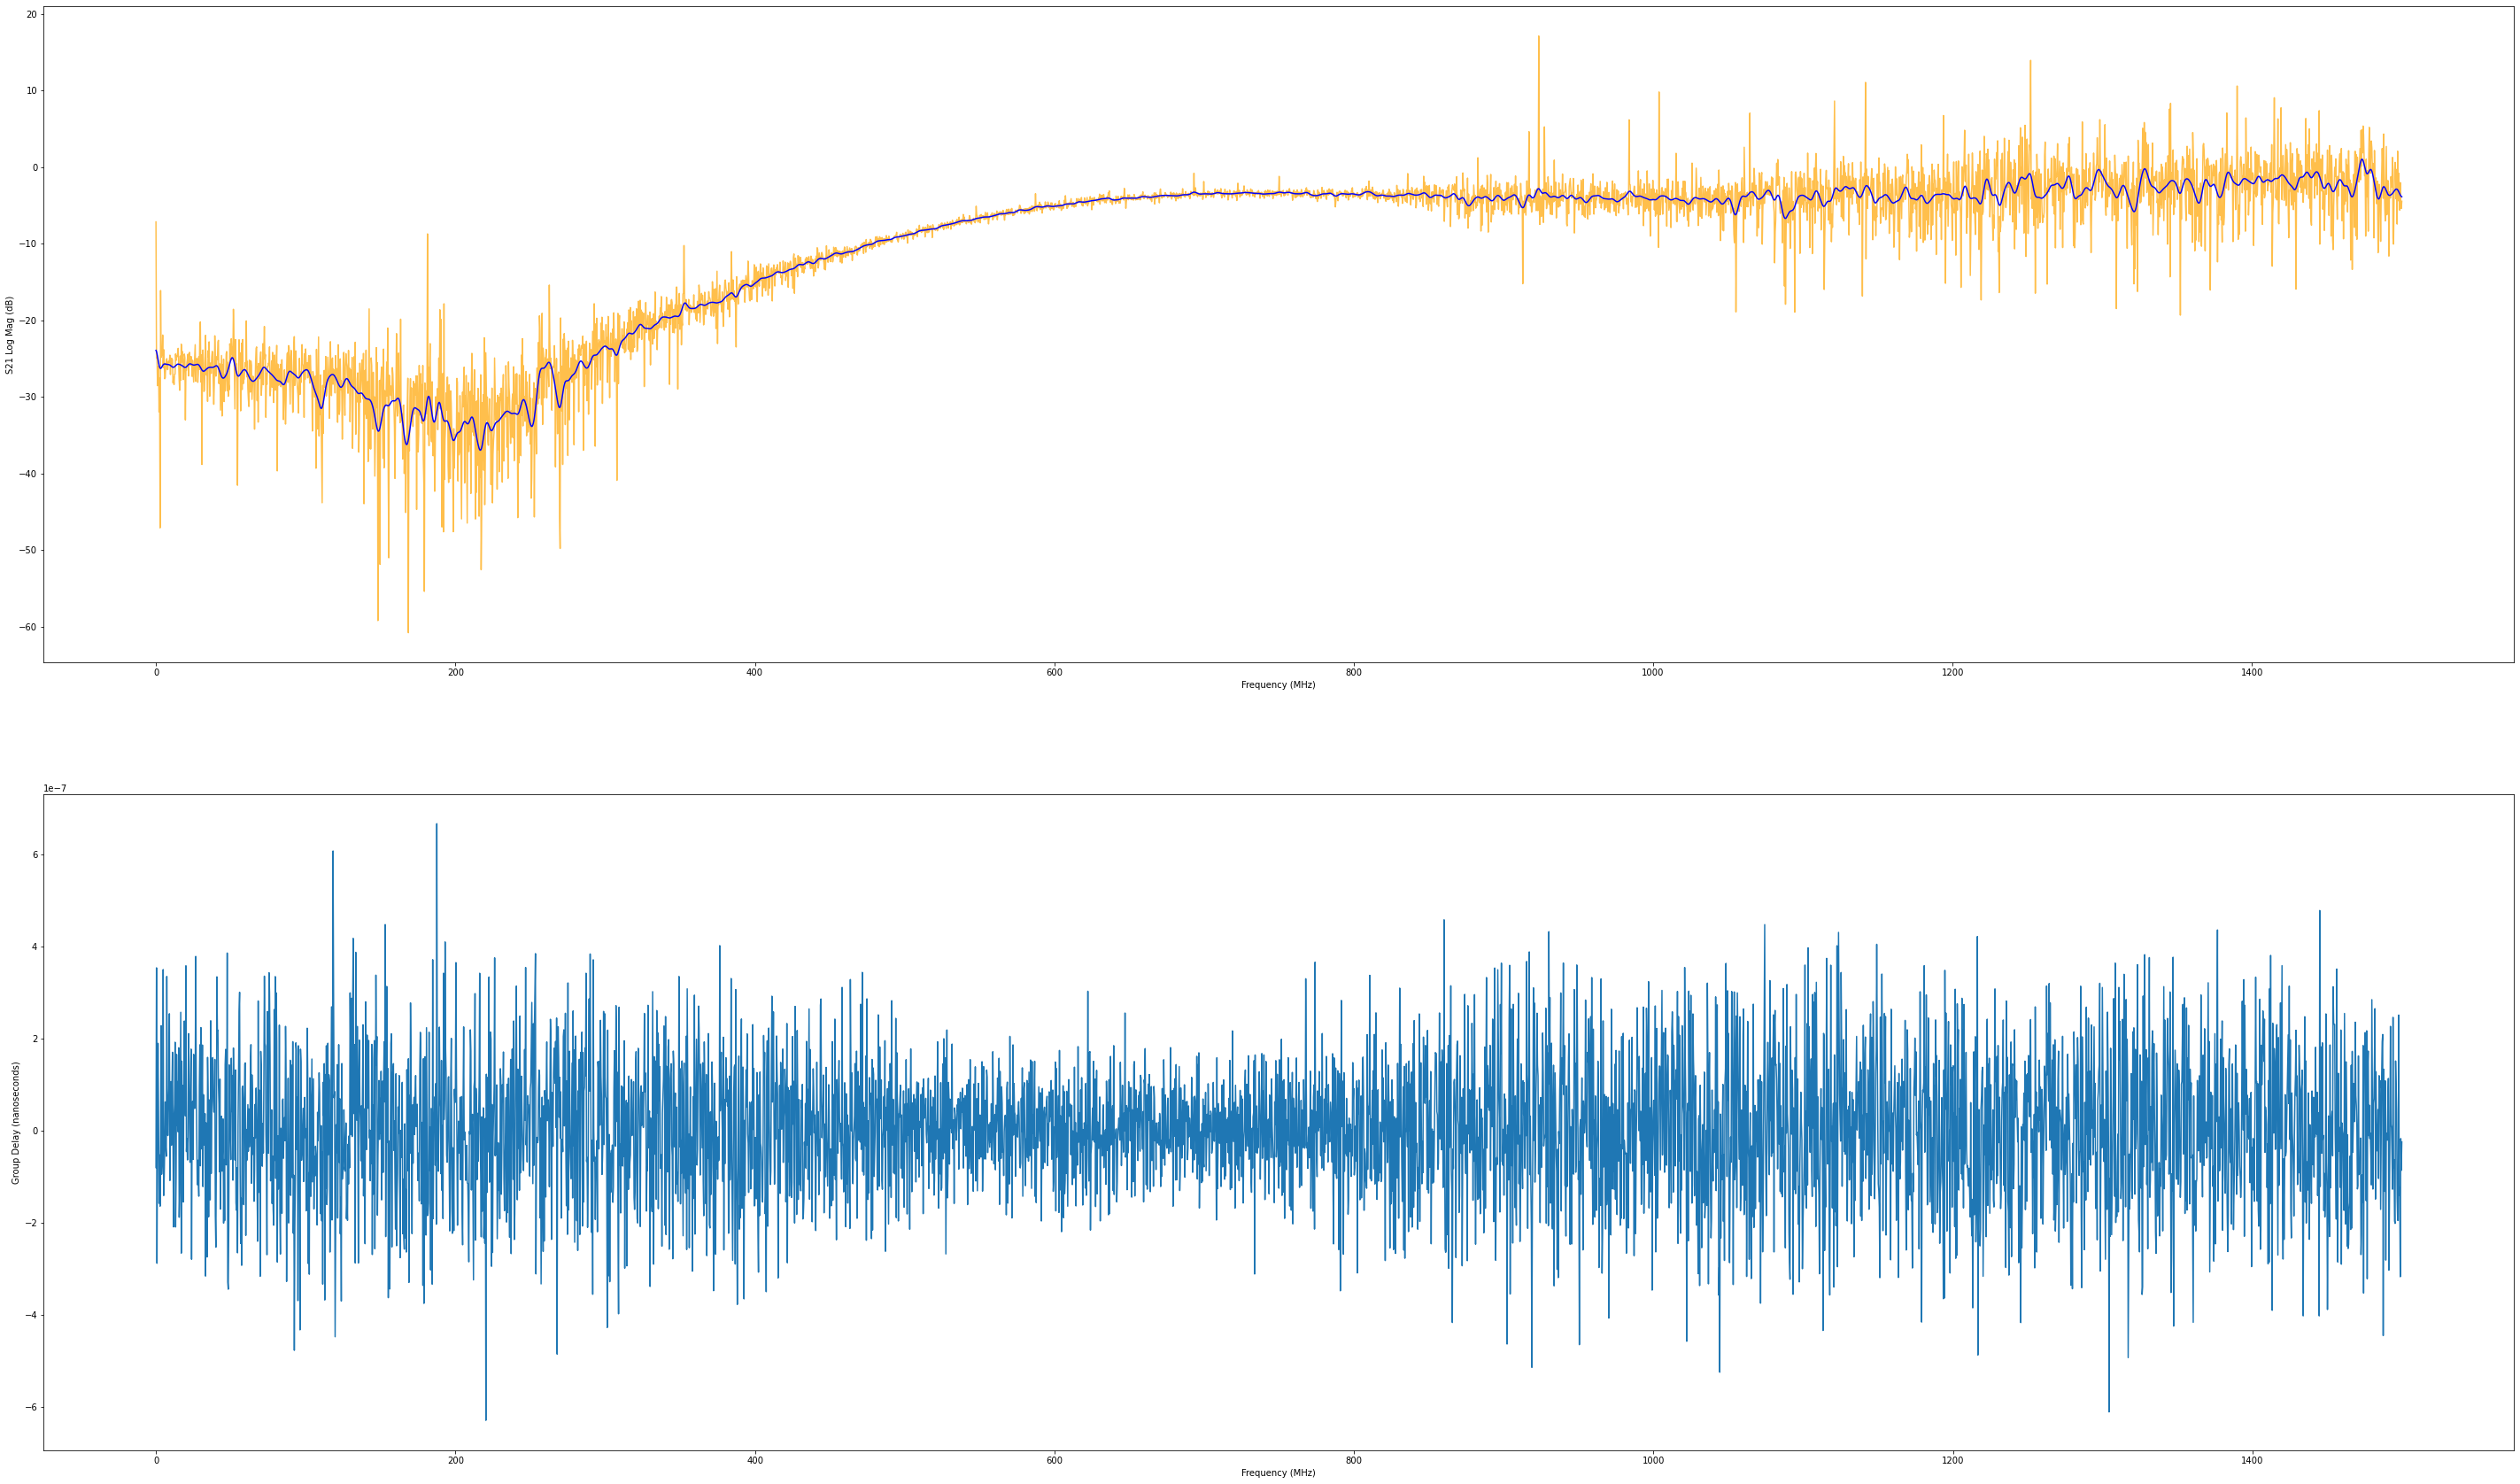

In [6]:
fig, (axS21,axGD) = plt.subplots(2, 1, figsize=(50, 30))

xf, S21_log_mag, group_delay_mean = capture_loop(1000,17)

axS21.plot(xf/10**6, S21_log_mag, color='orange', alpha=0.7)
axS21.set_xlabel("Frequency (MHz)")
axS21.set_ylabel("S21 Log Mag (dB)")

sigma = 5
y_smoothed_gauss = gaussian_filter1d(S21_log_mag, sigma=sigma)
axS21.plot(xf/10**6, y_smoothed_gauss, label='Smoothed (Gaussian)', color='blue')

axGD.plot(xf[:-1]/10**6, group_delay_mean)
axGD.set_xlabel("Frequency (MHz)")
axGD.set_ylabel("Group Delay (nanoseconds)")

plt.show()

In [7]:
print(xf[3])

1034245.0011491611
